In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv('../HW1_data/traffic/Casualties0514.csv')

In [3]:
# dataset.groupby("Casualty_Severity").count()
fatal_dataset = dataset[dataset["Casualty_Severity"]==1]
num_fatal = fatal_dataset.shape[0]
serious_dataset = dataset[dataset["Casualty_Severity"]==2].sample(n=num_fatal, random_state=35674, axis=0)
slight_dataset = dataset[dataset["Casualty_Severity"]==3].sample(n=num_fatal, random_state=25442, axis=0)
dataset = pd.concat([fatal_dataset, serious_dataset, slight_dataset],axis=0)
del fatal_dataset, serious_dataset, slight_dataset

In [4]:
dataset = dataset.drop(["Accident_Index", "Vehicle_Reference", "Casualty_Reference"], axis=1)
dataset = dataset.sample(frac=1, axis=0)
dataset.head()

,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
1351455,1,1,26,6,3,0,0,0,0,-1,1,1
1740504,2,2,32,6,3,0,0,1,0,0,9,1
1998542,3,1,5,1,3,5,4,0,0,0,0,1
800167,1,1,60,9,2,0,0,0,0,-1,1,1
1115993,1,1,59,9,1,0,0,0,0,-1,1,1


In [99]:
# Prepare data for Decision Tree
from sklearn.model_selection import train_test_split
X = dataset.drop(["Casualty_Severity"], axis=1)
y = dataset["Casualty_Severity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6357)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=6357)
del X, y
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(44297, 11)
(11075, 11)
(13844, 11)


In [100]:
from sklearn.tree import DecisionTreeClassifier
import pydotplus as pydot
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn import tree

# Vanilla Decision Tree
dt = DecisionTreeClassifier(criterion="entropy", random_state=4321)
dt.fit(X_train, y_train)
print("Fit end! ")
dt_val_score = dt.score(X_val, y_val)
print("Validation score: ", dt_val_score)

Fit end! 
Validation score:  0.43873589164785554


In [101]:
# Post-prune Decision Tree 
# My own implementation based on https://stackoverflow.com/questions/49428469/pruning-decision-trees/49496027#49496027
# Pruning based on validation score (if pruning a subtree gains better performance on validate set, then prune it)
from sklearn.tree._tree import TREE_LEAF

def prune_from_root(inner_tree, index):
    global dt_val_score
    memo = (inner_tree.children_left[index], inner_tree.children_right[index])
    inner_tree.children_left[index] = TREE_LEAF
    inner_tree.children_right[index] = TREE_LEAF
    new_score = dt.score(X_val, y_val)
    if new_score <= dt_val_score:
        inner_tree.children_left[index] = memo[0]
        inner_tree.children_right[index] = memo[1]
    else:
        dt_val_score = new_score

    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_from_root(inner_tree, inner_tree.children_left[index])
        prune_from_root(inner_tree, inner_tree.children_right[index])

def prune_from_leaf(inner_tree, index):
    global dt_val_score
    # if there are children, firstly visit them
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_from_leaf(inner_tree, inner_tree.children_left[index])
        prune_from_leaf(inner_tree, inner_tree.children_right[index])
        memo = (inner_tree.children_left[index], inner_tree.children_right[index])
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        new_score = dt.score(X_val, y_val)
        if new_score <= dt_val_score:
            inner_tree.children_left[index] = memo[0]
            inner_tree.children_right[index] = memo[1]
        else:
            dt_val_score = new_score

In [102]:
# prune from root
dt = DecisionTreeClassifier(criterion="entropy", random_state=4321)
dt.fit(X_train, y_train)
dt_val_score = dt.score(X_val, y_val)
print("no-prune validation score: ", dt_val_score)
print("no-prune test score: ", dt.score(X_test, y_test))
prune_from_root(dt.tree_, 0)
print("post-prune from root validation score: ", dt.score(X_val, y_val))
print("post-prune from root test score: ", dt.score(X_test, y_test))

no-prune validation score:  0.43873589164785554
no-prune test score:  0.4460416064721179
post-prune from root validation score:  0.4588713318284424
post-prune from root test score:  0.46865067899451024


In [103]:
# prune from leaf
# create an identical decision tree to the previous one using the same random_state
dt = DecisionTreeClassifier(criterion="entropy", random_state=4321)
dt.fit(X_train, y_train)
dt_val_score = dt.score(X_val, y_val)
print("no-prune validation score: ", dt_val_score)
print("no-prune test score: ", dt.score(X_test, y_test))
prune_from_leaf(dt.tree_, 0)
print("post-prune from leaf validation score: ", dt.score(X_val, y_val))
print("post-prune from leaf test score: ", dt.score(X_test, y_test))

no-prune validation score:  0.43873589164785554
no-prune test score:  0.4460416064721179
post-prune from leaf validation score:  0.5398645598194131
post-prune from leaf test score:  0.46850621207743426


In [106]:
# pre prune + post prune
best_val = 0
best_val_depth = 0
best_post_prune = ""
for depth in range(1, 30):
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=4321)
    dt.fit(X_train, y_train)
    dt_val_score = dt.score(X_val, y_val)
    print("===================", "depth=%d, post-prune=from root" % depth, sep='\n')
    print("no-prune validation score: ", dt_val_score)
    print("no-prune test score: ", dt.score(X_test, y_test))
    prune_from_root(dt.tree_, 0)
    val_score = dt.score(X_val, y_val)
    print("post-prune from root validation score: ", val_score)
    if val_score > best_val:
        best_val = val_score
        best_val_depth = depth
        best_post_prune = "from root"
    print("post-prune from root test score: ", dt.score(X_test, y_test))
    
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=4321)
    dt.fit(X_train, y_train)
    dt_val_score = dt.score(X_val, y_val)
    print("===================", "depth=%d, post-prune=from leaf" % depth, sep='\n')
    print("no-prune validation score: ", dt_val_score)
    print("no-prune test score: ", dt.score(X_test, y_test))
    prune_from_leaf(dt.tree_, 0)
    val_score = dt.score(X_val, y_val)
    print("post-prune from leaf validation score: ", val_score)
    if val_score >= best_val:
        best_val = val_score
        best_val_depth = depth
        best_post_prune = "from leaf"
    print("post-prune from leaf test score: ", dt.score(X_test, y_test))
print("*********************")
print("best_val=%f, best_val_depth=%d, best_post_prune=%s" % (best_val, best_val_depth, best_post_prune))

depth=1, post-prune=from root
no-prune validation score:  0.4302483069977427
no-prune test score:  0.43433978618896274
post-prune from root validation score:  0.4302483069977427
post-prune from root test score:  0.43433978618896274
depth=1, post-prune=from leaf
no-prune validation score:  0.4302483069977427
no-prune test score:  0.43433978618896274
post-prune from leaf validation score:  0.4302483069977427
post-prune from leaf test score:  0.43433978618896274
depth=2, post-prune=from root
no-prune validation score:  0.43548532731376977
no-prune test score:  0.4328951170182028
post-prune from root validation score:  0.43548532731376977
post-prune from root test score:  0.4328951170182028
depth=2, post-prune=from leaf
no-prune validation score:  0.43548532731376977
no-prune test score:  0.4328951170182028
post-prune from leaf validation score:  0.43548532731376977
post-prune from leaf test score:  0.4328951170182028
depth=3, post-prune=from root
no-prune validation score:  0.464288939051

post-prune from leaf validation score:  0.5272234762979684
post-prune from leaf test score:  0.48129153423865934
depth=18, post-prune=from root
no-prune validation score:  0.45580135440180586
no-prune test score:  0.46056053163825483
post-prune from root validation score:  0.4817155756207675
post-prune from root test score:  0.485842242126553
depth=18, post-prune=from leaf
no-prune validation score:  0.45580135440180586
no-prune test score:  0.46056053163825483
post-prune from leaf validation score:  0.531647855530474
post-prune from leaf test score:  0.4775353943946836
depth=19, post-prune=from root
no-prune validation score:  0.4524604966139955
no-prune test score:  0.458176827506501
post-prune from root validation score:  0.4817155756207675
post-prune from root test score:  0.485842242126553
depth=19, post-prune=from leaf
no-prune validation score:  0.4524604966139955
no-prune test score:  0.458176827506501
post-prune from leaf validation score:  0.5337246049661399
post-prune from l

In [107]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

best_val = 0
best_depth = 0
best_n_estimators = 0
for depth in range(1, 10):
    for n_estimators in [100, 200, 400, 1000]:
        ada_dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
        adaboost = AdaBoostClassifier(base_estimator=ada_dt, n_estimators=n_estimators)
        adaboost.fit(X_train,y_train)
        val_score = adaboost.score(X_val,y_val)
        print("max_depth=%d, n_estimator=%d, val_score=%f" % (depth, n_estimators, val_score))
        if val_score > best_val:
            best_val = val_score
            best_depth = depth
            best_n_estimators = n_estimators
            
print("Best validation score: ", best_val)
print("Best depth: ", best_depth)
print("Best estimators: ", best_n_estimators)
ada_dt = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth)
adaboost = AdaBoostClassifier(base_estimator=ada_dt, n_estimators=best_n_estimators)
adaboost.fit(X_train,y_train)
test_score = adaboost.score(X_test, y_test)
print("Test score: ", test_score)

max_depth=1, n_estimator=100, val_score=0.495711
max_depth=1, n_estimator=200, val_score=0.498420
max_depth=1, n_estimator=400, val_score=0.498420
max_depth=1, n_estimator=1000, val_score=0.498691
max_depth=2, n_estimator=100, val_score=0.496253
max_depth=2, n_estimator=200, val_score=0.496524
max_depth=2, n_estimator=400, val_score=0.496614
max_depth=2, n_estimator=1000, val_score=0.494718
max_depth=3, n_estimator=100, val_score=0.492641
max_depth=3, n_estimator=200, val_score=0.490745
max_depth=3, n_estimator=400, val_score=0.487404
max_depth=3, n_estimator=1000, val_score=0.476840
max_depth=4, n_estimator=100, val_score=0.482799
max_depth=4, n_estimator=200, val_score=0.478555
max_depth=4, n_estimator=400, val_score=0.467178
max_depth=4, n_estimator=1000, val_score=0.456975
max_depth=5, n_estimator=100, val_score=0.478104
max_depth=5, n_estimator=200, val_score=0.466546
max_depth=5, n_estimator=400, val_score=0.454086
max_depth=5, n_estimator=1000, val_score=0.441264
max_depth=6, n_

Test score:  0.5020947702976019


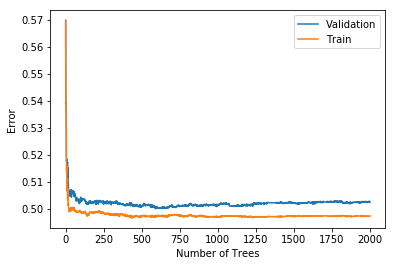

In [113]:
ada_dt = DecisionTreeClassifier(criterion="entropy", max_depth=1)
adaboost = AdaBoostClassifier(base_estimator=ada_dt, n_estimators=2000)
adaboost.fit(X_train,y_train)
test_score = adaboost.score(X_test, y_test)
print("Test score: ", test_score)

train_mid_error = []
for mid_predict in adaboost.staged_predict(X_train):
    train_mid_error.append(1 - accuracy_score(mid_predict, y_train))
val_mid_error = []
for mid_predict in adaboost.staged_predict(X_val):
    val_mid_error.append(1 - accuracy_score(mid_predict, y_val))

number_of_predict = len(val_mid_error)
train_mid_error = train_mid_error[:number_of_predict]

plt.plot(range(1, number_of_predict + 1),
         val_mid_error, label='Validation')
plt.plot(range(1, number_of_predict + 1),
         train_mid_error, label='Train')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.show()

In [5]:
dataset.head()

,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
1351455,1,1,26,6,3,0,0,0,0,-1,1,1
1740504,2,2,32,6,3,0,0,1,0,0,9,1
1998542,3,1,5,1,3,5,4,0,0,0,0,1
800167,1,1,60,9,2,0,0,0,0,-1,1,1
1115993,1,1,59,9,1,0,0,0,0,-1,1,1


In [6]:
for col in ["Casualty_Class", "Sex_of_Casualty", "Age_Band_of_Casualty", "Pedestrian_Location", "Pedestrian_Movement", "Car_Passenger", "Bus_or_Coach_Passenger", "Pedestrian_Road_Maintenance_Worker", "Casualty_Type", "Casualty_Home_Area_Type"]: 
    need_remove_non = False
    if dataset[col].min() < 0:
        need_remove_non = True
    dataset = pd.concat([dataset,pd.get_dummies(dataset[col], prefix=col)],axis=1).drop([col],axis=1)
    if need_remove_non:
        dataset = dataset.drop([col+"_-1"], axis=1)
dataset.head()

,Age_of_Casualty,Casualty_Severity,Casualty_Class_1,Casualty_Class_2,Casualty_Class_3,Sex_of_Casualty_1,Sex_of_Casualty_2,Age_Band_of_Casualty_1,Age_Band_of_Casualty_2,Age_Band_of_Casualty_3,...,Casualty_Type_18,Casualty_Type_19,Casualty_Type_20,Casualty_Type_21,Casualty_Type_22,Casualty_Type_90,Casualty_Type_97,Casualty_Home_Area_Type_1,Casualty_Home_Area_Type_2,Casualty_Home_Area_Type_3
1351455,26,3,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1740504,32,3,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1998542,5,3,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
800167,60,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1115993,59,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
dataset.columns

Index(['Age_of_Casualty', 'Casualty_Severity', 'Casualty_Class_1',
       'Casualty_Class_2', 'Casualty_Class_3', 'Sex_of_Casualty_1',
       'Sex_of_Casualty_2', 'Age_Band_of_Casualty_1', 'Age_Band_of_Casualty_2',
       'Age_Band_of_Casualty_3', 'Age_Band_of_Casualty_4',
       'Age_Band_of_Casualty_5', 'Age_Band_of_Casualty_6',
       'Age_Band_of_Casualty_7', 'Age_Band_of_Casualty_8',
       'Age_Band_of_Casualty_9', 'Age_Band_of_Casualty_10',
       'Age_Band_of_Casualty_11', 'Pedestrian_Location_0',
       'Pedestrian_Location_1', 'Pedestrian_Location_2',
       'Pedestrian_Location_3', 'Pedestrian_Location_4',
       'Pedestrian_Location_5', 'Pedestrian_Location_6',
       'Pedestrian_Location_7', 'Pedestrian_Location_8',
       'Pedestrian_Location_9', 'Pedestrian_Location_10',
       'Pedestrian_Movement_0', 'Pedestrian_Movement_1',
       'Pedestrian_Movement_2', 'Pedestrian_Movement_3',
       'Pedestrian_Movement_4', 'Pedestrian_Movement_5',
       'Pedestrian_Movement_6', 

In [8]:
X = dataset.drop(["Casualty_Severity"], axis=1)
y = dataset["Casualty_Severity"]

In [9]:
print(X.shape)
print(y.shape)

(69216, 71)
(69216,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6357)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=6357)
del X, y
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(44297, 71)
(11075, 71)
(13844, 71)


In [11]:
X_train.describe()

,Age_of_Casualty,Casualty_Class_1,Casualty_Class_2,Casualty_Class_3,Sex_of_Casualty_1,Sex_of_Casualty_2,Age_Band_of_Casualty_1,Age_Band_of_Casualty_2,Age_Band_of_Casualty_3,Age_Band_of_Casualty_4,...,Casualty_Type_18,Casualty_Type_19,Casualty_Type_20,Casualty_Type_21,Casualty_Type_22,Casualty_Type_90,Casualty_Type_97,Casualty_Home_Area_Type_1,Casualty_Home_Area_Type_2,Casualty_Home_Area_Type_3
count,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,...,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.00000,44297.000000
mean,37.541955,0.612795,0.197666,0.189539,0.668488,0.331332,0.013996,0.022462,0.044405,0.144547,...,0.000023,0.018647,0.002574,0.007224,0.000361,0.005734,0.000045,0.624376,0.08978,0.122988
std,20.818863,0.487117,0.398243,0.391940,0.470762,0.470697,0.117477,0.148182,0.205995,0.351648,...,0.004751,0.135276,0.050665,0.084687,0.019002,0.075507,0.006719,0.484289,0.28587,0.328427
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,34.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
75%,51.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
max,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [128]:
from sklearn.neural_network import MLPClassifier

best_val = 0
best_layer = (0)
best_activation = ""
for first_layer in range(100, 301, 100):
    for activation in ['identity', 'logistic', 'tanh', 'relu']:
        mlp = MLPClassifier(hidden_layer_sizes=(first_layer), activation=activation, max_iter=1000)
        mlp.fit(X_train, y_train)
        val_score = mlp.score(X_val, y_val)
        print("first_layer=%d, activation=%s, val_score=%f" % (first_layer, activation, val_score))
        if val_score > best_val:
            best_val = val_score
            best_layer = (first_layer)
            best_activation = activation
    for second_layer in range(100, 301, 100):
        for activation in ['identity', 'logistic', 'tanh', 'relu']:
            mlp = MLPClassifier(hidden_layer_sizes=(first_layer, second_layer), activation=activation, max_iter=1000)
            mlp.fit(X_train, y_train)
            val_score = mlp.score(X_val, y_val)
            print("first_layer=%d, second_layer=%d, activation=%s, val_score=%f" % (first_layer, second_layer, activation, val_score))
            if val_score > best_val:
                best_val = val_score
                best_layer = (first_layer, second_layer)
                best_activation = activation

print(best_val)
print(best_layer)
print(best_activation)
mlp = MLPClassifier(hidden_layer_sizes=(best_layer), activation=best_activation, max_iter=1000)
mlp.fit(X_train, y_train)
mlp.score(X_test, y_test)

first_layer=100, activation=identity, val_score=0.479910
first_layer=100, activation=logistic, val_score=0.499594
first_layer=100, activation=tanh, val_score=0.499774
first_layer=100, activation=relu, val_score=0.500677
first_layer=100, second_layer=100, activation=identity, val_score=0.496795
first_layer=100, second_layer=100, activation=logistic, val_score=0.501129
first_layer=100, second_layer=100, activation=tanh, val_score=0.487946
first_layer=100, second_layer=100, activation=relu, val_score=0.483883
first_layer=100, second_layer=200, activation=identity, val_score=0.489120
first_layer=100, second_layer=200, activation=logistic, val_score=0.501851
first_layer=100, second_layer=200, activation=tanh, val_score=0.499594
first_layer=100, second_layer=200, activation=relu, val_score=0.487133
first_layer=100, second_layer=300, activation=identity, val_score=0.472957
first_layer=100, second_layer=300, activation=logistic, val_score=0.489120
first_layer=100, second_layer=300, activation=

0.5018058364634499

In [ ]:
from sklearn import svm
from random import random

best_val = 0
best_C = 0
all_C_val_score = []
all_C = []
for i in range(5):
    log_C = random() * 10 - 5
    C = np.exp(log_C)
    clf = svm.SVC(C=C, kernel="linear", decision_function_shape='ovr')
    clf.fit(X_train,y_train)
    val_score = clf.score(X_val,y_val)
    print("C=%f, val_score=%f" % (C, val_score))
    if val_score > best_val:
        best_val = val_score
        best_C = C
    all_C.append(C)
    all_C_val_score.append(val_score)

plt.scatter(all_C, all_C_val_score)
plt.show()
print("Best validation score: ", best_val)
print("Best C: ", best_C)